In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44295")
client

<Client: 'tcp://127.0.0.1:44295' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

dCs = 1e-5
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

/tmp/ipykernel_38615/3829648471.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs


In [7]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

## $$\Pi(k) = -\frac{1}{C_\Psi}\int_{\kappa>k} \mathcal{R}\left[\tilde{q'} \widetilde{({\bf u}\cdot\nabla q)'}^*\right] x_0^2 \kappa\, d\kappa$$

# Wavelet
## Native grid

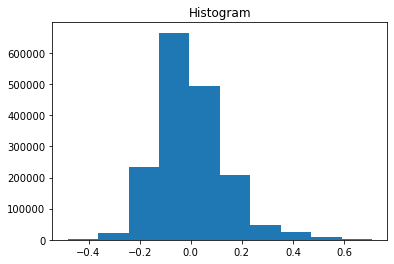

ValueError: Dimensions {'XC', 'YC'} do not exist. Expected one or more of ('nmemb', 'Z', 'YG', 'XG')

In [8]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:
            
            dsgrd = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (0,years[0])), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    iters=ntimes[0,0],
                                    prefix=['diag_ocnSnap'], delta_t=2e2,
                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                        )
            
            dsq = xr.open_zarr(op.join(tdgs,
                                       '5Dave/run%4d/EddyErtelPV/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                    XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                   ).chunk({'Z':1})
            
            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                              XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

        
            grid = Grid(ds, periodic=[])

            v = ds.VVEL.where(ds.maskS!=0.)
            u = ds.UVEL.where(ds.maskW!=0.)

            zeta = (grid.diff(v*ds.dyC,'X',boundary='extend')
                    - grid.diff(u*ds.dxC,'Y',boundary='extend')
                   ) / ds.rAz
            zetap = zeta.isel(Z=[14,24]) - zeta.isel(Z=[14,24]).mean('nmemb',skipna=True)
            
            f = xr.apply_ufunc(gsw.f, ds.YC)
            (zetap/f).isel(nmemb=0,Z=0).plot()
            plt.show()
            

            Az = ((grid.interp(u,'Y',boundary='extend') 
                   * grid.interp(grid.diff(zeta*grid.interp(ds.dyC,'X',boundary='extend'),
                                           'X',boundary='extend'),
                                 'X',boundary='extend').isel(Z=[14,24])
                   + grid.interp(v,'X',boundary='extend') 
                     * grid.interp(grid.diff(zeta*grid.interp(ds.dxC,'Y',boundary='extend'),'Y',boundary='extend'),
                                   'Y',boundary='extend').isel(Z=[14,24])
                  ) / ds.rAz).isel(YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            print(Az)
            
            Azp = Az - Az.mean('nmemb',skipna=True)
            Azp.isel(nmemb=0,Z=0).plot()
            plt.show()

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = Aqp.shape
            Azp = xr.DataArray(Azp.data, dims=Aqp.dims, 
                               coords={'nmemb':Aqp.nmemb,'Z':Aqp.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
            zetap = xr.DataArray(zetap.data, dims=zetap.dims, 
                                 coords={'nmemb':zetap.nmemb,'Z':zetap.Z,
                                         'YC':np.arange(0,N[-2]*dy,dy),
                                         'XC':np.arange(0,N[-1]*dx,dx)}
                                )

            
            ntheta = 36
            iso_csQAq = xwavelet.wvlt_cross_spectrum(
                    zetap, Azp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            
            
#             eta = -(iso_csQAq*np.diff(iso_csQAq.scale**-1)[0])[::-1].cumsum('scale')[::-1]
            eta = -(iso_csQAq*np.diff(iso_csQAq.scale**-1)[0]).cumsum('scale')
            print(eta)

            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
#             ax2 = ax.twinx()
            ax3 = ax.twiny()
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e13,
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e13,
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e13,
                    'k', lw=2, label=r"Isotropic")
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(angle=0,Z=1).mean(['nmemb'])*4e15,
                     'r:', lw=2)
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*4e15,
                     'c:', lw=2)
            ax.plot((iso_csQAq.scale)**-1*1e3, eta.isel(Z=1).mean(['nmemb','angle'])*4e15,
                     'k:', lw=2, label=r"$\times 4\times10^{2}$ (Z=-1137)")
#             ax.plot((iso_csUAq.scale)**-1*1e3, ((iso_psPV.scale/xo)**-1)**-1*1e-19, 
#                      ls='--', c='grey', alpha=.8, label=r"$k^{-1}$")
#             ax.plot((iso_psPV.scale)**-1*1e3, ((iso_psPV.scale/xo)**-2)**-2*6e-22, 
#                      ls='-.', c='grey', alpha=.8, label=r"$k^{-2}$")
#             ax2.plot((iso_csUAq.scale)**-1*1e3, xr.ones_like(iso_psPV.scale)*1e-19, 
#                      ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
#             ax.set_yscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_ylim([-2*np.abs(eta.isel(Z=0).mean(['nmemb','angle'])).max()*1e13,
                         2*np.abs(eta.isel(Z=0).mean(['nmemb','angle'])).max()*1e13])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-13}$) [s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
            ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='lower left', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/Vort-specflux_Region%02d.pdf' % reg))
            plt.show()

## Uniform grid

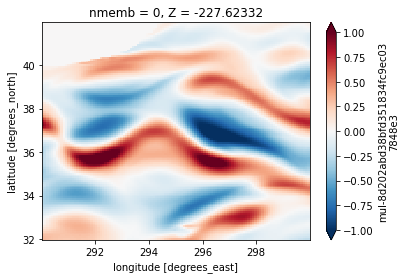

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


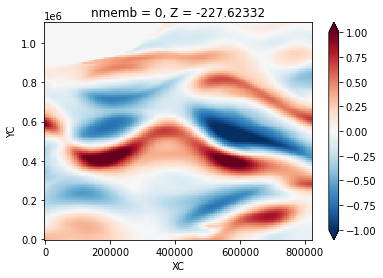

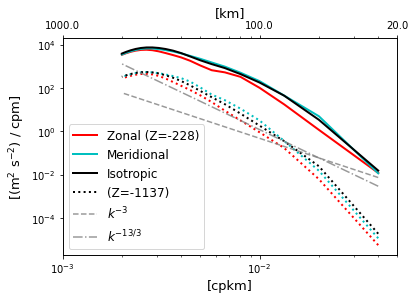

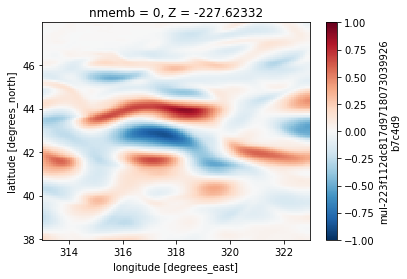

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


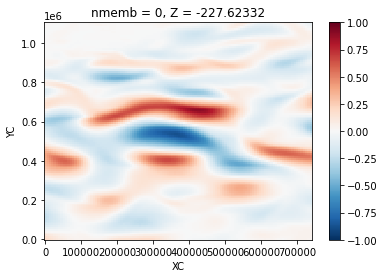

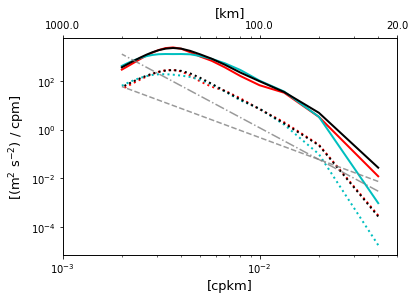

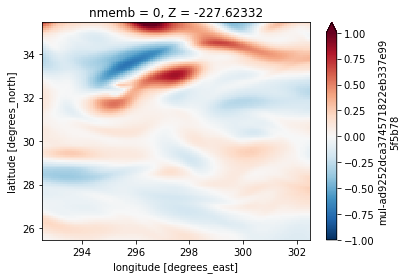

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


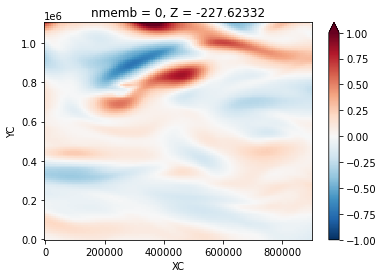

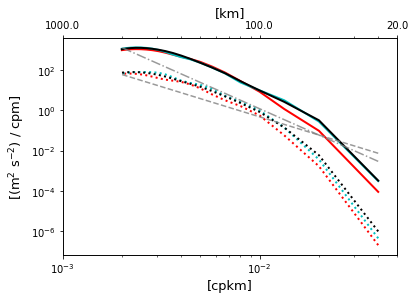

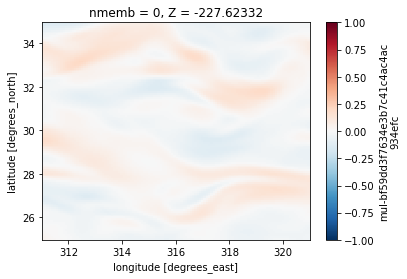

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


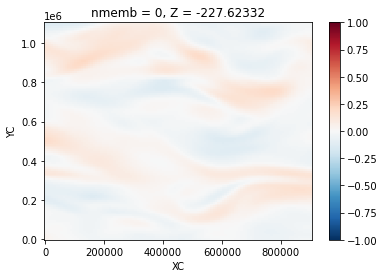

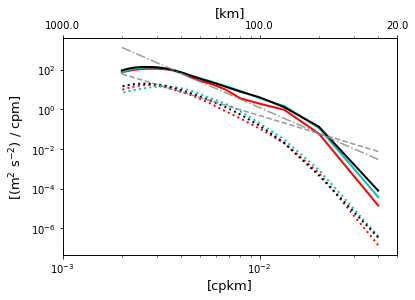

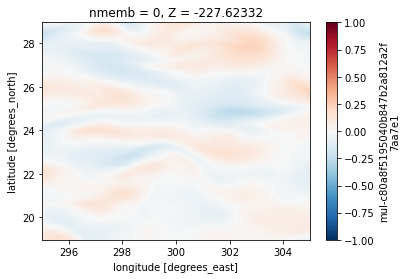

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


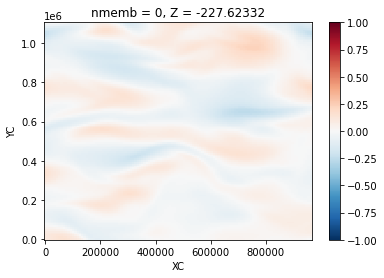

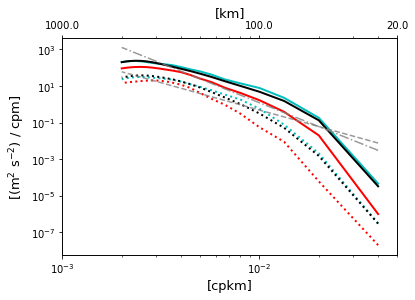

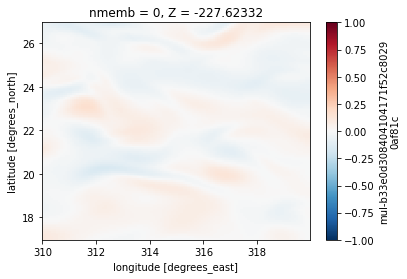

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


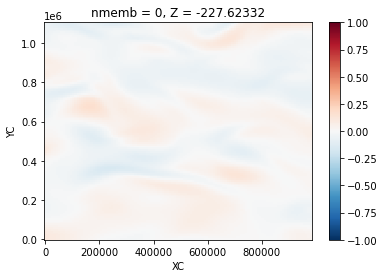

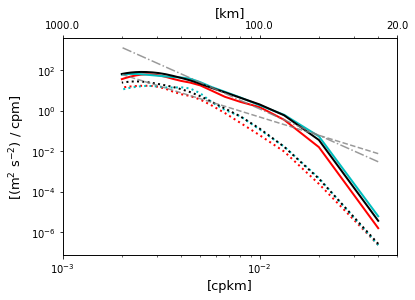

In [25]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)
        
        grid = Grid(ds, periodic=[])

        up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                         'X',boundary='extend'
                        ).isel(Z=[14,24]).load().interpolate_na(dim='XC'
                                                               ).interpolate_na(dim='YC'
                                                                               ).fillna(0.)
        vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                         'Y',boundary='extend'
                        ).isel(Z=[14,24]).load().interpolate_na(dim='YC'
                                                               ).interpolate_na(dim='XC'
                                                                               ).fillna(0.)
        up.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r')
        plt.show()
        
        xT = grid.cumsum(ds.dxC,'X',boundary='extend')
        yT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        xT = (xT - xT.isel(XC=0)).values.flatten()
        yT = (yT - yT.isel(YC=0)).values.flatten()
        print(ds.dxC.mean(), ds.dyC.mean())
        dx = ds.dxC.min().values
        dy = ds.dyC.min().values
        N = up.isel(nmemb=0,Z=0).shape
        
        uterp = xr.DataArray(np.ones_like(up), dims=up.dims,
                             coords={'nmemb':nmembs,'Z':up.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
        vterp = xr.DataArray(np.ones_like(vp), dims=vp.dims,
                             coords={'nmemb':nmembs,'Z':vp.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
        mask = xr.DataArray(~ds.maskC.isel(Z=[14,24]).load(), 
                            dims=vp.isel(nmemb=0).dims,
                            coords={'Z':vp.Z,
                                    'YC':np.arange(0,N[-2]*dy,dy),
                                    'XC':np.arange(0,N[-1]*dx,dx)}
                           )
#         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
        xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
        for nn in range(len(nmembs)):
            for iz in range(len(up.Z)):
#                 f = interp2d(dxT, dyT,
#                              up.isel(nmemb=nn,Z=iz).data, 
#                             )
                uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), up.isel(nmemb=nn,Z=iz).values.flatten(),
                                                        (xxx, yyy) 
                                                       ).T
#                 tck = bisplrep(dxT, dyT, 
#                                up.isel(nmemb=nn,Z=iz).values.flatten(), 
# #                                s=np.prod(N[-2:])
# #                                s=np.prod(N[-2:])-np.sqrt(2*np.prod(N[-2:]))
#                                s=0.
#                               )
#                 uterp.isel(nmemb=nn,Z=iz)[:] = np.ma.masked_array(bisplev(xx[:,0], yy[0,:], tck),
#                                                                   mask.isel(Z=iz).data
#                                                                  )
#                 del tck
#                 f = interp2d(dxT, dyT,
#                              vp.isel(nmemb=nn,Z=iz).data, 
#                             )
                vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), vp.isel(nmemb=nn,Z=iz).values.flatten(),
                                                        (xxx, yyy) 
                                                       ).T
#                 tck = bisplrep(dxT, dyT, vp.isel(nmemb=nn,Z=iz).data, 
# #                                s=np.prod(N[-2:])
# #                                s=np.prod(N[-2:])-np.sqrt(2*np.prod(N[-2:]))
#                                s=0.
#                               )
#                 vterp.isel(nmemb=nn,Z=iz)[:] = np.ma.masked_array(bisplev(xx[:,0], yy[0,:], tck),
#                                                                   mask.isel(Z=iz).data
#                                                                  )
#                 del tck
                if nn == 0 and iz == 0:
                    uterp.isel(nmemb=nn,Z=iz).plot(vmax=1, vmin=-1, cmap='RdBu_r')
                    plt.show()
#             print(nn)

        
        iso_psU = xwavelet.wvlt_power_spectrum(
                uterp.chunk({'nmemb':1}), s, dim=["YC", "XC"], xo=xo
        )
        iso_psV = xwavelet.wvlt_power_spectrum(
                vterp.chunk({'nmemb':1}), s, dim=["YC", "XC"], xo=xo
        )
        
        fig, ax = plt.subplots()
        ax2 = ax.twiny()
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=0).mean(['nmemb']),
                'r', lw=2, label=r"Zonal (Z=-228)")
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=3,Z=0).mean(['nmemb']),
                'c', lw=2, label=r"Meridional")
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=0).mean(['nmemb','angle']),
                'k', lw=2, label=r"Isotropic")
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=1).mean(['nmemb']),
                'r:', lw=2)
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=3,Z=1).mean(['nmemb']),
                'c:', lw=2)
        ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=1).mean(['nmemb','angle']),
                'k:', lw=2, label=r"(Z=-1137)")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                 ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
                 ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                 ls='--', c='grey', alpha=0)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax.set_xlim([1e-3,5e-2])
        ax2.set_xlim([1e-3,5e-2])
        ax2.set_xticks([1e-3,1e-2,5e-2])
        ax2.set_xticklabels([1e3,1e2,2e1])
        ax.set_xlabel(r"[cpkm]", fontsize=13)
        ax2.set_xlabel(r"[km]", fontsize=13)
        ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
        if reg == 0:
            ax.legend(loc='lower left', fontsize=12)
        plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/interpKE-spec_Region%02d.pdf' % reg))
        plt.show()

# Fourier

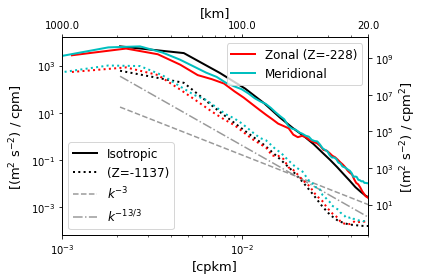

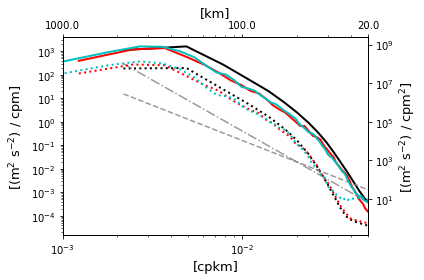

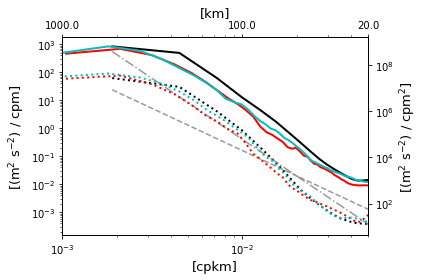

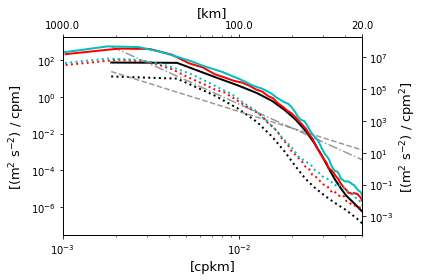

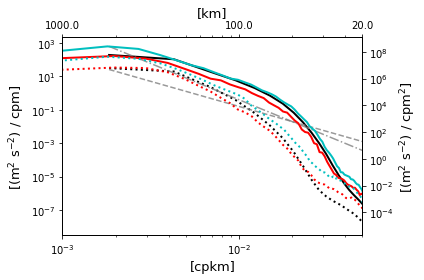

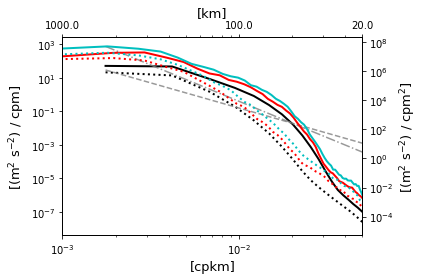

In [12]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)
        
        grid = Grid(ds, periodic=[])

        up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                         'X',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                               ).interpolate_na(dim='YC'
                                                                               ).fillna(0.)
        vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                         'Y',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='YC'
                                                               ).interpolate_na(dim='XC'
                                                                               ).fillna(0.)
        
        dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
        dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
        N = up.shape
        up = xr.DataArray(up.data, dims=up.dims, 
                          coords={'nmemb':up.nmemb,'Z':up.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
        vp = xr.DataArray(vp.data, dims=vp.dims, 
                          coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
        
        psU = xrft.power_spectrum(
                up, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True
        )
        psV = xrft.power_spectrum(
                vp, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True
        )
        
        iso_psU = xrft.isotropic_power_spectrum(
                up, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_psV = xrft.isotropic_power_spectrum(
                vp, dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        ax2 = ax.twinx()
        ax3 = ax.twiny()
        ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=0,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                'r', lw=2, label=r"Zonal (Z=-228)")
        ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=0,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                'c', lw=2, label=r"Meridional")
        ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=0,freq_r=slice(None,None)).mean(['nmemb']),
                'k', lw=2, label=r"Isotropic")
        ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=1,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                'r:', lw=2)
        ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                .5*(psU + psV).isel(Z=1,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                'c:', lw=2)
        ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=1,freq_r=slice(None,None)).mean(['nmemb']),
                'k:', lw=2, label=r"(Z=-1137)")
        ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-3*2e-2, 
                 ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
        ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-(13/3)*2e-2, 
                 ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
        ax3.plot(iso_psU.freq_r*1e3, xr.ones_like(iso_psU.freq_r)*1e1, 
                 ls='--', c='grey', alpha=0)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax.set_xlim([1e-3,5e-2])
        ax3.set_xlim([1e-3,5e-2])
        ax3.set_xticks([1e-3,1e-2,5e-2])
        ax3.set_xticklabels([1e3,1e2,2e1])
        ax.set_xlabel(r"[cpkm]", fontsize=13)
        ax3.set_xlabel(r"[km]", fontsize=13)
        ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
        ax2.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm$^2$]", fontsize=13)
        if reg == 0:
            ax.legend(loc='lower left', fontsize=12)
            ax2.legend(loc='upper right', fontsize=12)
        plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/KE-Fourierspec_Region%02d.pdf' % reg))
        plt.show()